# EDA Bureau and Bureau_Balance
In this analysis, we explore the bureau and bureau_balance data to examine the credit history of Home Credit customers as reported by other financial institutions to the Credit Bureau. The findings show that defaulters tend to have shorter credit histories, meaning they applied for credit much closer to their current loan application date compared to non-defaulters. They also have shorter periods since their last credit update, indicating that their previous credit accounts were settled or updated more recently. Interestingly, some records show very old end dates (over 100 years), suggesting those debts were settled long ago. Additionally, non-defaulters tend to make earlier payments, while defaulters are more likely to delay their repayments.

# Load Libraries

In [109]:
import numpy as np
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots





# Load datasets

In [135]:
bureau = pd.read_csv(r'D:\python\visualize\final_project\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_bureau.csv')
bureau_bal= pd.read_csv(r'D:\python\visualize\final_project\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_bureau_balance.csv')

In [136]:
train = pd.read_csv(r'D:\python\visualize\final_project\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_application_train.csv')

# Basic analyzing

In [137]:
print(bureau.shape)
print(bureau_bal.shape)


(1465325, 17)
(27299925, 3)


In [138]:
print(f'The shape of bureau.csv is: {bureau.shape}')
print('-'*100)
print(f'Number of unique SK_ID_BUREAU in bureau.csv are: {len(bureau.SK_ID_BUREAU.unique())}')
print(f'Number of unique SK_ID_CURR in bureau.csv are: {len(bureau.SK_ID_CURR.unique())}')
print(f'Number of overlapping SK_ID_CURR in application_train.csv and bureau.csv are: {len(set(train.SK_ID_CURR.unique()).intersection(set(bureau.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Number of duplicate values in bureau: {bureau.shape[0] - bureau.duplicated().shape[0]}')
print('-'*100)
display(bureau.head(5))

The shape of bureau.csv is: (1465325, 17)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_BUREAU in bureau.csv are: 1465325
Number of unique SK_ID_CURR in bureau.csv are: 263491
Number of overlapping SK_ID_CURR in application_train.csv and bureau.csv are: 210809
----------------------------------------------------------------------------------------------------
Number of duplicate values in bureau: 0
----------------------------------------------------------------------------------------------------


,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR
0,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,254629
1,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,254629
2,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,254629
3,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,254629
4,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,254629


1. The bureau.csv file contains over 1.4M datapoints, with 17 features. Out of these 17 features, two are SK_ID_CURR and SK_ID_BUREAU.
- SK_ID_BUREAU is the loan ID of the client's previous loan from other financial institutions. There may be multiple previous loans corresponding to a single SK_ID_CURR which depends on client's borrowing pattern.
- SK_ID_CURR is the loan ID of client's current loan with Home Credit.
- The rest of the features contain other stats such as DAYS_CREDIT, AMT_CREDIT_SUM, CREDIT_TYPE, etc.
2. There are 263k unique SK_ID_CURR in bureau out of which:
- There are 210k SK_ID_CURR in bureau which are present in application_train out of total of total 263k of application_train's unique SK_ID_CURR. This means that some of the applicants in current loan application with Home Credit Group do not have any previous Credit history with Credit Bureau Department.


# Merge data

In [139]:
bureau_merge = bureau.merge(train[['SK_ID_CURR','TARGET']], on = 'SK_ID_CURR', how = 'left')
bureau_merge.head()

,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR,TARGET
0,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,254629,0.0
1,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,254629,0.0
2,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,254629,0.0
3,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,254629,0.0
4,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,254629,0.0


In [140]:
bureau_and_bureau_bal = pd.merge(bureau_merge, bureau_bal, on = 'SK_ID_BUREAU', how = 'left')

In [141]:
bureau_and_bureau_bal.head()

,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR,TARGET,MONTHS_BALANCE,STATUS
0,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,254629,0.0,NaN,NaN
1,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,254629,0.0,NaN,NaN
2,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,254629,0.0,NaN,NaN
3,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,254629,0.0,NaN,NaN
4,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,254629,0.0,NaN,NaN


In [142]:
bureau_and_bureau_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15643422 entries, 0 to 15643421
Data columns (total 20 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_BUREAU            int64  
 1   CREDIT_ACTIVE           object 
 2   CREDIT_CURRENCY         object 
 3   DAYS_CREDIT             int64  
 4   CREDIT_DAY_OVERDUE      int64  
 5   DAYS_CREDIT_ENDDATE     float64
 6   DAYS_ENDDATE_FACT       float64
 7   AMT_CREDIT_MAX_OVERDUE  float64
 8   CNT_CREDIT_PROLONG      int64  
 9   AMT_CREDIT_SUM          float64
 10  AMT_CREDIT_SUM_DEBT     float64
 11  AMT_CREDIT_SUM_LIMIT    float64
 12  AMT_CREDIT_SUM_OVERDUE  float64
 13  CREDIT_TYPE             object 
 14  DAYS_CREDIT_UPDATE      int64  
 15  AMT_ANNUITY             float64
 16  SK_ID_CURR              int64  
 17  TARGET                  float64
 18  MONTHS_BALANCE          float64
 19  STATUS                  object 
dtypes: float64(10), int64(6), object(4)
memory usage: 2.3+ GB


In [143]:
bureau_and_bureau_bal.describe()

,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR,TARGET,MONTHS_BALANCE
count,1.564342e+07,1.564342e+07,1.564342e+07,1.485782e+07,1.172994e+07,4.449836e+06,1.564342e+07,1.564342e+07,1.301196e+07,9.316142e+06,1.564342e+07,1.564342e+07,8.997850e+06,1.564342e+07,1.252433e+07,1.470161e+07
mean,5.970646e+06,-1.535300e+03,9.765046e-01,3.874712e+01,-1.238235e+03,6.913733e+03,9.558714e-03,3.383958e+05,9.236338e+04,5.086597e+03,1.403726e+01,-8.047170e+02,1.413999e+04,1.540358e+05,7.014980e-02,-2.863028e+01
std,5.156930e+05,7.702194e+02,4.056978e+01,4.810811e+03,7.183741e+02,4.670952e+05,1.205894e-01,1.011578e+06,6.512671e+05,4.095134e+04,2.625574e+03,7.113515e+02,2.769364e+05,8.904781e+04,2.553993e-01,2.206971e+01
min,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.600000e+01
25%,5.559095e+06,-2.229000e+03,0.000000e+00,-1.606000e+03,-1.774000e+03,0.000000e+00,0.000000e+00,4.936950e+04,0.000000e+00,0.000000e+00,0.000000e+00,-1.164000e+03,0.000000e+00,7.634300e+04,0.000000e+00,-4.300000e+01
50%,6.008944e+06,-1.479000e+03,0.000000e+00,-8.380000e+02,-1.147000e+03,0.000000e+00,0.000000e+00,1.188225e+05,0.000000e+00,0.000000e+00,0.000000e+00,-7.260000e+02,0.000000e+00,1.547100e+05,0.000000e+00,-2.400000e+01
75%,6.397827e+06,-9.150000e+02,0.000000e+00,-1.000000e+00,-6.660000e+02,0.000000e+00,0.000000e+00,2.947500e+05,0.000000e+00,0.000000e+00,0.000000e+00,-1.690000e+02,1.038339e+04,2.311740e+05,0.000000e+00,-1.000000e+01
max,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,3.960000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,5.958668e+07,3.075090e+05,1.000000e+00,0.000000e+00


# Check missing values

In [144]:
bureau_missing = pd.DataFrame({
    'Missing Values' : bureau.isnull().sum(),
    'Percentage missing values' : bureau.isnull().sum()/len(bureau)*100,
})

bureau_missing = bureau_missing[bureau_missing['Missing Values'] > 0]
bureau_missing

,Missing Values,Percentage missing values
DAYS_CREDIT_ENDDATE,89098,6.080426
DAYS_ENDDATE_FACT,544673,37.170798
AMT_CREDIT_MAX_OVERDUE,948545,64.732738
AMT_CREDIT_SUM,3,0.000205
AMT_CREDIT_SUM_DEBT,223094,15.224882
AMT_CREDIT_SUM_LIMIT,489670,33.417160
AMT_ANNUITY,1130013,77.116885


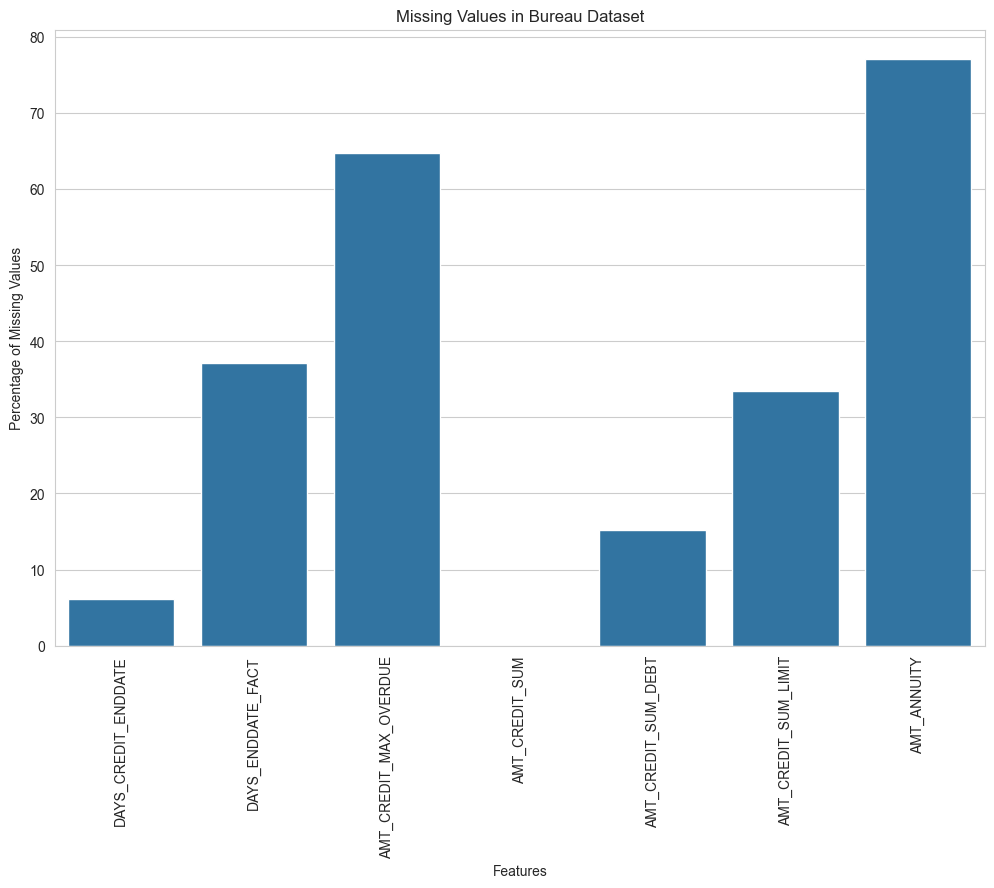

In [145]:
bureau_missing = bureau_missing.transpose()
plt.figure(figsize=(12, 8))
sns.barplot(x=bureau_missing.columns, y=bureau_missing.loc['Percentage missing values'])
plt.title('Missing Values in Bureau Dataset')
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=90)
plt.show()

- Out of 17 features, there are 7 features which contain NaN values.
- The highest NaN values are observed with the column AMT_ANNUITY which has over 70% missing values.

In [146]:
bureau_and_bureau_bal[bureau_and_bureau_bal['AMT_CREDIT_SUM'].isnull()]

,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR,TARGET,MONTHS_BALANCE,STATUS
2820714,6008179,Active,currency 1,0,0,NaN,NaN,NaN,0,NaN,654993.0,NaN,0.0,Another type of loan,-5,NaN,286316,0.0,NaN,NaN
4480431,6064357,Active,currency 1,0,0,NaN,NaN,NaN,0,NaN,2250000.0,NaN,0.0,Another type of loan,-16,NaN,159071,0.0,NaN,NaN
13030337,6121986,Closed,currency 1,0,0,NaN,-72.0,NaN,0,NaN,0.0,NaN,0.0,Another type of loan,-23,NaN,30694,0.0,0.0,C


SK_IDBUREAU : 6121986 has closed, target =0 -> có thể đã trả hết nợ -> AMT_CREDIT_SUM fill 0, 
2 ID còn lại fill mean 

In [147]:
bureau_and_bureau_bal.loc[bureau_and_bureau_bal['SK_ID_BUREAU'] == 6121986, 'AMT_CREDIT_SUM'] = bureau_and_bureau_bal.loc[bureau_and_bureau_bal['SK_ID_BUREAU'] == 6121986, 'AMT_CREDIT_SUM'].fillna(0)

In [148]:
endate_fact_null= bureau_and_bureau_bal[bureau_and_bureau_bal['DAYS_ENDDATE_FACT'].isnull()]

In [149]:
endate_fact_null['CREDIT_ACTIVE'].value_counts()

CREDIT_ACTIVE
Active      3849830
Sold          62340
Closed         1263
Bad debt         51
Name: count, dtype: int64

DAYS_ENDATE_FACT cái nào active,sold, bad debt thì fill bằng số rất lớn 99999 coi như khoản vay vẫn active

In [150]:
mean_value_closed = bureau_and_bureau_bal.loc[bureau_and_bureau_bal['CREDIT_ACTIVE'] == 'Closed', 'DAYS_ENDDATE_FACT'].mean()
bureau_and_bureau_bal.loc[(bureau_and_bureau_bal['CREDIT_ACTIVE'] == 'Closed') & (bureau_and_bureau_bal['DAYS_ENDDATE_FACT'].isnull()), 'DAYS_ENDDATE_FACT'] = mean_value_closed

# Handling missing data

In [151]:
bureau_and_bureau_bal[bureau_and_bureau_bal['AMT_ANNUITY'].isnull() & (bureau_and_bureau_bal['DAYS_CREDIT_ENDDATE'].values > 0) & (bureau_and_bureau_bal['DAYS_ENDDATE_FACT'].values < 0)]

,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR,TARGET,MONTHS_BALANCE,STATUS
57,5714515,Closed,currency 1,-1656,0,170.0,-468.0,NaN,0,296730.0,0.0,0.0,0.0,Consumer credit,-466,NaN,122422,0.0,NaN,NaN
63,5714529,Closed,currency 1,-672,0,10285.0,-531.0,NaN,0,135000.0,0.0,0.0,0.0,Credit card,-429,NaN,168522,0.0,NaN,NaN
64,5714530,Closed,currency 1,-1304,0,1253.0,-1287.0,NaN,0,225000.0,0.0,0.0,0.0,Consumer credit,-429,NaN,168522,0.0,NaN,NaN
66,5714532,Closed,currency 1,-1130,0,331.0,-858.0,NaN,0,450000.0,0.0,0.0,0.0,Consumer credit,-847,NaN,168522,0.0,NaN,NaN
105,5714573,Closed,currency 1,-1188,0,1369.0,-1090.0,NaN,0,450000.0,0.0,0.0,0.0,Consumer credit,-429,NaN,254093,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15643300,5052629,Closed,currency 1,-532,0,45.0,-227.0,NaN,0,450000.0,0.0,0.0,0.0,Consumer credit,-31,NaN,66820,NaN,-13.0,0
15643301,5052629,Closed,currency 1,-532,0,45.0,-227.0,NaN,0,450000.0,0.0,0.0,0.0,Consumer credit,-31,NaN,66820,NaN,-14.0,0
15643302,5052629,Closed,currency 1,-532,0,45.0,-227.0,NaN,0,450000.0,0.0,0.0,0.0,Consumer credit,-31,NaN,66820,NaN,-15.0,0
15643303,5052629,Closed,currency 1,-532,0,45.0,-227.0,NaN,0,450000.0,0.0,0.0,0.0,Consumer credit,-31,NaN,66820,NaN,-16.0,0


In [152]:
bureau_and_bureau_bal[bureau_and_bureau_bal['AMT_ANNUITY'].isnull() & (bureau_and_bureau_bal['DAYS_ENDDATE_FACT'].values > 0)]

,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR,TARGET,MONTHS_BALANCE,STATUS


In [153]:
bureau_and_bureau_bal[bureau_and_bureau_bal['DAYS_ENDDATE_FACT'].values > 0]

,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR,TARGET,MONTHS_BALANCE,STATUS


In [154]:
# Current credit amount for the Credit Bureau credit
bureau_and_bureau_bal['AMT_CREDIT_SUM'].fillna(bureau_and_bureau_bal['AMT_CREDIT_SUM'].median(), inplace = True)

# Remaining duration of CB credit (in days) at the time of application in Home Credit
bureau_and_bureau_bal['DAYS_CREDIT_ENDDATE'].fillna(bureau_and_bureau_bal['DAYS_CREDIT_ENDDATE'].median(), inplace = True)

# giả sử missing values là những khoản vay đã thanh toán hết
bureau_and_bureau_bal['AMT_CREDIT_SUM_DEBT'].fillna(0, inplace = True)

# giả sử missing values là khoản vay của những khách hàng không có hạn mức tín dụng
bureau_and_bureau_bal['AMT_CREDIT_SUM_LIMIT'].fillna(0, inplace = True)

# giả sử missing values là khoản vay không có lịch sử quá hạn thanh toán
bureau_and_bureau_bal['AMT_CREDIT_MAX_OVERDUE'].fillna(0, inplace = True)

# giả sử missing values là khoản vay vẫn active
bureau_and_bureau_bal['DAYS_ENDDATE_FACT'].fillna(99999, inplace = True)

# trong tất cả trường hợp amt_annuity trống, days_enddate_fact đều âm tức khách hàng đã thanh toán hết khoản vay
bureau_and_bureau_bal['AMT_ANNUITY'].fillna(0, inplace = True)

# Functions for visualization

In [155]:
def plot_count_by_target_bar(df, columns, target):
    for col in columns:
        plt.figure(figsize=(10, 6)) 
        sns.countplot(data=df, x=col, hue=target)
        plt.xticks(rotation=45)
        plt.title(f'Count of {col} by {target}')
        plt.legend(title=target)
        plt.show()

In [156]:
def plot_count_by_target_barh(df, columns, target):
    for col in columns:
        plt.figure(figsize=(9, 6)) 
        order = df[col].value_counts().index
        sns.countplot(data=df, y=col, hue=target, order=order)
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.title(f'Count of {col} by {target}')
        plt.legend(title=target)
        plt.show()

In [157]:
def plot_count_distribution(dataframe, data_column, title=None, x_label=None, y_label=None):
    plt.figure(figsize=(10, 6))
    sns.countplot(y=data_column, data=dataframe, order=dataframe[data_column].value_counts().index)
    
    if title is None:
        title = f'Distribution of {data_column}'
    plt.title(title)
    
    if x_label is None:
        x_label = 'Count'
    plt.xlabel(x_label)
    
    if y_label is None:
        y_label = data_column
    plt.ylabel(y_label)
    
    plt.show()

In [158]:
def plot_distribution_by_target(data, column, target_column ='TARGET'):
    plt.figure(figsize=(10, 8))
    
    sns.kdeplot(data.loc[data[target_column] == 0, column], label=f'{target_column} == 0', color='blue')
    sns.kdeplot(data.loc[data[target_column] == 1, column], label=f'{target_column} == 1', color='red')
    
    x_label = column
    
    plt.xlabel(x_label)
    plt.ylabel('Density')
    plt.title(f'Distribution of {x_label}')
    plt.legend()
    plt.show()

In [159]:
def plot_cdf(data, column_name, log_scale = False, figsize = (12,8)):
    
    '''
    Function to plot CDF of a continuour variable
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose CDF is to be plotted
        log_scale: bool, default = True
            Whether to use log-scale (for widely varying values) or not
        figsize: tuple, default = (12,8)
            The size of figure to be plotted    
    '''
    
        
    percentile_values = data[[column_name]].dropna().sort_values(by = column_name)
    percentile_values['Percentile'] = [ele / (len(percentile_values) - 1) for ele in range(len(percentile_values))]

    plt.figure(figsize = figsize)
    if log_scale:
        plt.xscale('log')
        plt.xlabel(column_name + ' - (log-scale)')
    else:
        plt.xlabel(column_name)
    plt.plot(percentile_values[column_name], percentile_values['Percentile'], color = 'red')
    plt.ylabel('Probability')
    plt.title('CDF of {}'.format(column_name))
    plt.show()

In [160]:
class correlation_matrix:
    '''
    Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.
    Contains three methods:
        1. init method
        2. plot_correlation_matrix method
        3. target_top_corr method
    '''
    
    def __init__(self, data, columns_to_drop, figsize = (25,23), mask_upper = True, tight_layout = True, 
                  linewidth = 0.1, fontsize = 10, cmap = 'Blues'):  
        '''  
        Function to initialize the class members. 
        
        Inputs:
            data: DataFrame
                The DataFrame from which to build correlation matrix
            columns_to_drop: list
                Columns which have to be dropped while building the correlation matrix (for example the Loan ID)
            figsize: tuple, default = (25,23)
                Size of the figure to be plotted
            mask_upper: bool, default = True
                Whether to plot only the lower triangle of heatmap or plot full.
            tight_layout: bool, default = True
                Whether to keep tight layout or not
            linewidth: float/int, default = 0.1
                The linewidth to use for heatmap
            fontsize: int, default = 10
                The font size for the X and Y tick labels
            cmap: str, default = 'Blues'
                The colormap to be used for heatmap

        Returns:
            None
        '''
        
        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap 
                 
    def plot_correlation_matrix(self):
        '''
        Function to plot the Correlation Matrix Heatmap
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        print('-' * 100)
        #building the correlation dataframe
        self.corr_data = self.data.drop(self.columns_to_drop + ['TARGET'], axis = 1).corr()

        if self.mask_upper:
            #masking the heatmap to show only lower triangle. This is to save the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Correlation Heatmap for Numerical features")
        plt.show()
        print("-"*100)
    
    def target_top_corr(self, target_top_columns = 10):
        '''
        Function to return the Top Correlated features with the Target
        
        Inputs:
            self
            target_top_columns: int, default = 10
                The number of top correlated features with target to display
            
        Returns:
            Top correlated features DataFrame.
        '''
        
        phik_target_arr = np.zeros(self.corr_data.shape[1])
        #calculating the Phik-Correlation with Target
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[['TARGET', column]].phik_matrix().iloc[0,1]
        #getting the top correlated columns and their values
        top_corr_target_df = pd.DataFrame({'Column Name': self.corr_data.columns, 'Phik-Correlation' : phik_target_arr})
        top_corr_target_df = top_corr_target_df.sort_values(by = 'Phik-Correlation', ascending = False)
        
        return top_corr_target_df.iloc[:target_top_columns]

In [161]:
def plot_phik_matrix(data, categorical_columns, figsize = (20,20), mask_upper = True, tight_layout = True, linewidth = 0.1, fontsize = 10, cmap = 'Blues', show_target_top_corr = True, target_top_columns = 10):
    
    '''
    Function to Phi_k matrix for categorical features
    
    Inputs:
        data: DataFrame
            The DataFrame from which to build correlation matrix
        categorical_columns: list
            List of categorical columns whose PhiK values are to be plotted
        figsize: tuple, default = (25,23)
            Size of the figure to be plotted
        mask_upper: bool, default = True
            Whether to plot only the lower triangle of heatmap or plot full.
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        linewidth: float/int, default = 0.1
            The linewidth to use for heatmap
        fontsize: int, default = 10
            The font size for the X and Y tick labels
        cmap: str, default = 'Blues'
            The colormap to be used for heatmap
        show_target_top_corr: bool, default = True
            Whether to show top/highly correlated features with Target.
        target_top_columns: int, default = 10
            The number of top correlated features with target to display
    '''
    
    #first fetching only the categorical features
    data_for_phik = data[categorical_columns].astype('object')
    phik_matrix = data_for_phik.phik_matrix()
    
    print('-'*100)
    
    if mask_upper:
        mask_array = np.ones(phik_matrix.shape)
        mask_array = np.triu(mask_array)
    else:
        mask_array = np.zeros(phik_matrix.shape)
        
    plt.figure(figsize = figsize, tight_layout = tight_layout)
    sns.heatmap(phik_matrix, annot = False, mask = mask_array, linewidth = linewidth, cmap = cmap)
    plt.xticks(rotation = 90, fontsize = fontsize)
    plt.yticks(rotation = 0, fontsize = fontsize)
    plt.title("Phi-K Correlation Heatmap for Categorical Features")
    plt.show()
    print("-"*100)

    if show_target_top_corr:
        #Seeing the top columns with highest correlation with the target variable in application_train
        print("Categories with highest values of Phi-K Correlation value with Target Variable are:")
        phik_df = pd.DataFrame({'Column Name' : phik_matrix.TARGET.index[1:], 'Phik-Correlation' : phik_matrix.TARGET.values[1:]})
        phik_df = phik_df.sort_values(by = 'Phik-Correlation', ascending = False)
        display(phik_df.head(target_top_columns))
        print("-"*100) 

In [162]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):
    
    '''
    Function to plot continuous variables distribution
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', 'CDF', box', 'violin']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''

    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
        
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'blue', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'red', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
            
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='blue')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='red')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()

In [163]:
def print_percentiles(data, column_name, percentiles = None):
    
    '''
    Function to print percentile values for given column
    
    Inputs:
        data: DataFrame
            The DataFrame from which to print percentiles
        column_name: str
            Column's name whose percentiles are to be printed
        percentiles: list, default = None
            The list of percentiles to print, if not given, default are printed
    '''
    
    print('-'*100)
    if not percentiles:
        percentiles = list(range(0,80,25)) + list(range(90,101,2))
    for i in percentiles:
        print(f'The {i}th percentile value of {column_name} is {np.percentile(data[column_name].dropna(), i)}')
    print("-"*100)

### Phi-K Matrix

----------------------------------------------------------------------------------------------------


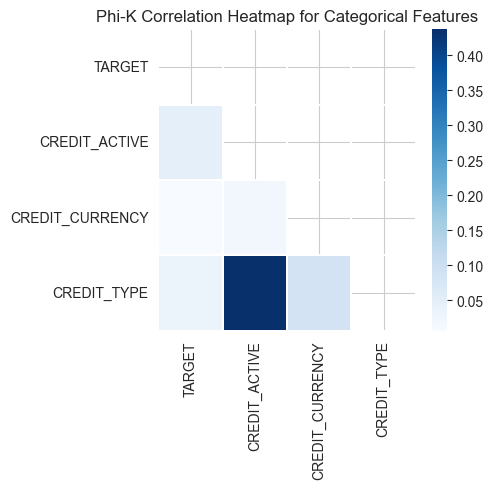

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


,Column Name,Phik-Correlation
0,CREDIT_ACTIVE,0.046893
2,CREDIT_TYPE,0.032166
1,CREDIT_CURRENCY,0.006879


----------------------------------------------------------------------------------------------------


In [164]:
cols_for_phik = ['TARGET','CREDIT_ACTIVE','CREDIT_CURRENCY','CREDIT_TYPE']
plot_phik_matrix(bureau_and_bureau_bal, cols_for_phik,  figsize = (5,5))

The above heatmap shows the Phi-K Correlation values between categorical values.

- From the Phi-K Correlation Coefficient, we see that the variable CREDIT_TYPE shows some association with the variable CREDIT_ACTIVE.
- We see that the Categorical Variables don't really have a high association with TARGET variable, especially the CREDIT_CURRENCY feature.

### Correlation Matrix of Features

----------------------------------------------------------------------------------------------------


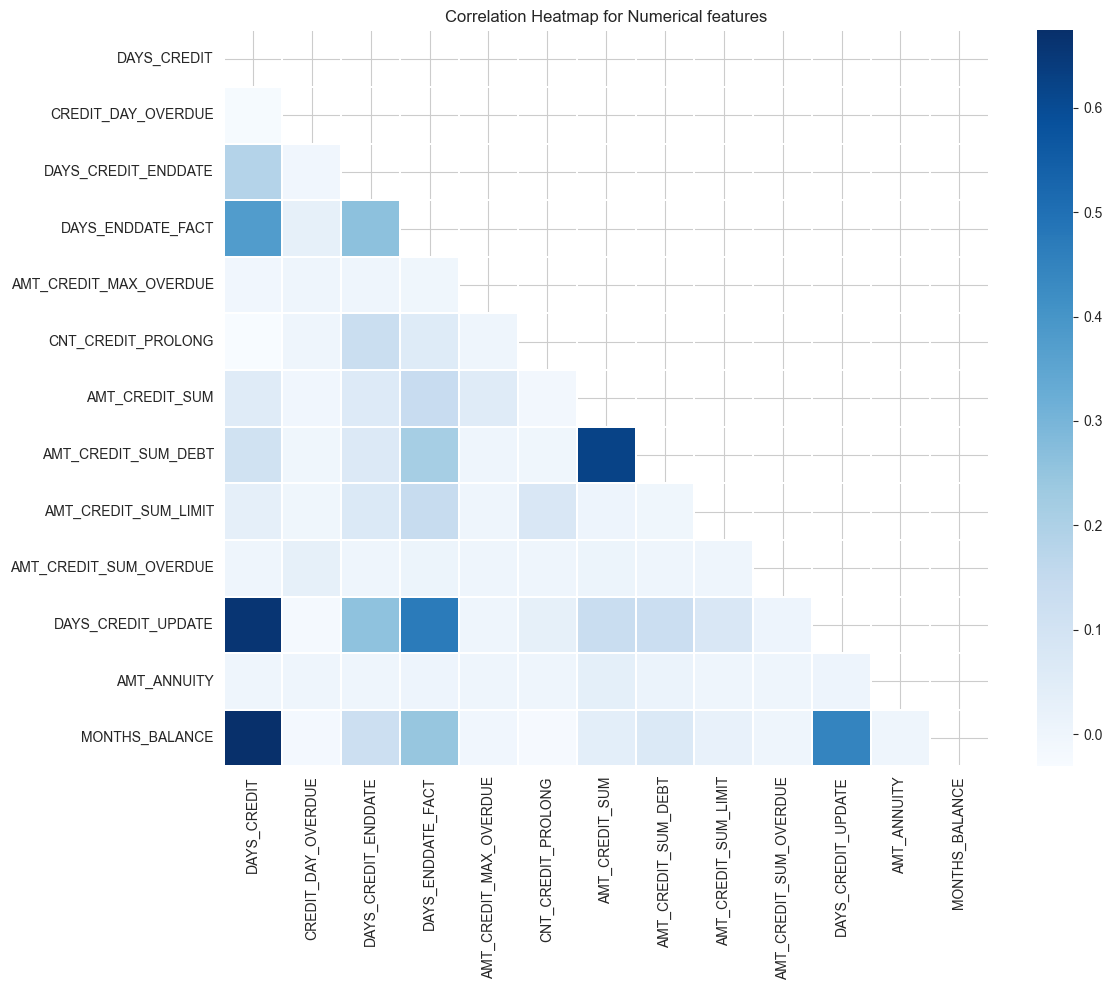

----------------------------------------------------------------------------------------------------


In [165]:
# Select only numeric columns for correlation matrix
numeric_columns = bureau_and_bureau_bal.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns = [col for col in numeric_columns if col not in ['SK_ID_CURR', 'SK_ID_BUREAU']]

corr_mat = correlation_matrix(bureau_and_bureau_bal[numeric_columns + ['TARGET']], [], cmap = 'Blues', figsize = (12,10))
corr_mat.plot_correlation_matrix()

- It can be observed that most of the heatmap has light colors, which shows little to no correlation.
- However, we can see some dark shades which represent high correlation.
- The high correlation is particularly observed for features:
1. DAYS_CREDIT and DAYS_CREDIT_UPDATE
2. DAYS_CREDIT and MONTHS_BALANCE
3. DAYS_ENDDATE_FACT and DAYS_CREDIT_UPDATE
4. AMT_CREDIT_SUM and AMT_CREDIT_SUM_DEBT
5. DAYS_CREDIT_UPDATE and MONTHS_BALANCE
6. DAYS_ENDDATE_FACT and DAYS_CREDIT

# Categorical variables

In [166]:
categorical_columns = bureau.select_dtypes('object').columns
categorical_columns

Index(['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE'], dtype='object')

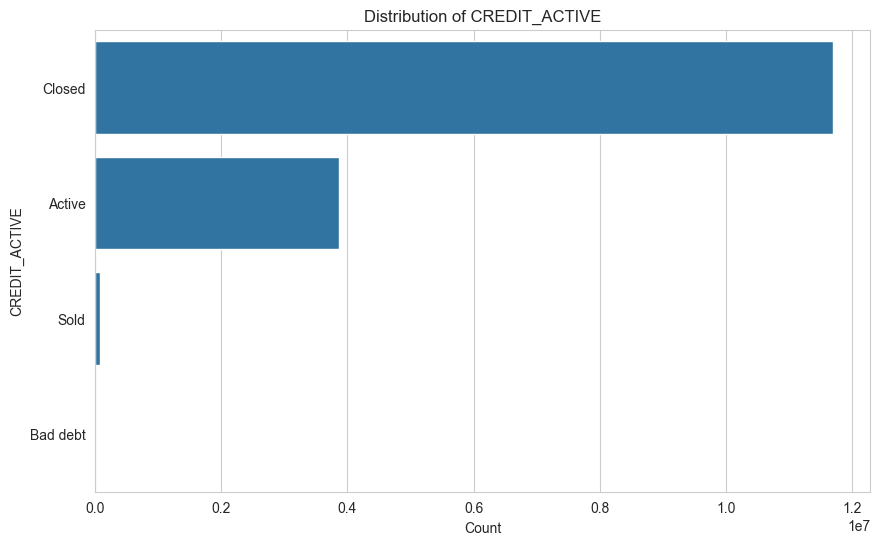

In [167]:
plot_count_distribution(bureau_and_bureau_bal, 'CREDIT_ACTIVE')

Since 'Bad debt' and 'Sold' value counts  are much smaller than 'Closed' and 'Active'. Additionally, 'Bad debt' and 'Sold' are not very relevant to the column 'CREDIT_ACTIVE', we will replace 'Bad debt' and 'Sold' with 'Active'.

In [168]:
bureau_and_bureau_bal['CREDIT_ACTIVE'] = bureau_and_bureau_bal['CREDIT_ACTIVE'].replace(['Bad debt', 'Sold'],'Active')

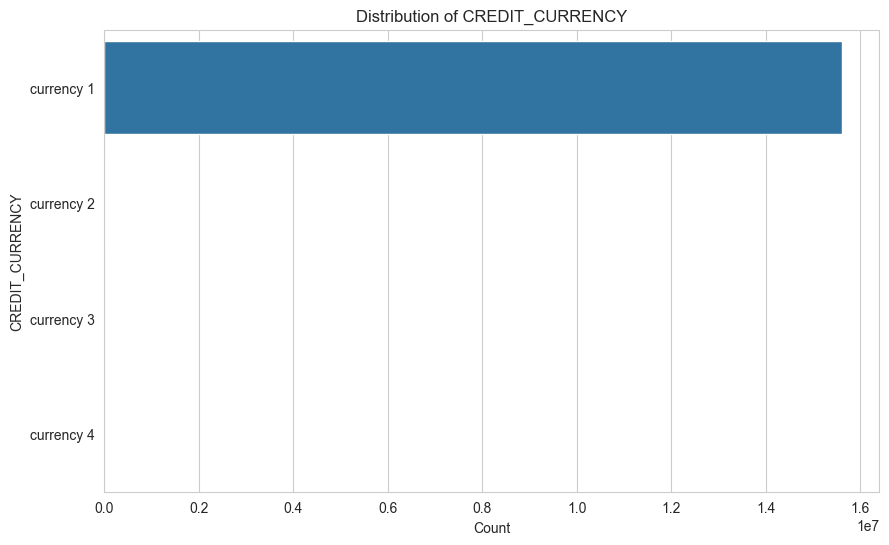

In [169]:
plot_count_distribution(bureau_and_bureau_bal, 'CREDIT_CURRENCY')

In [170]:
currency_1_count = bureau_and_bureau_bal[bureau_and_bureau_bal['CREDIT_CURRENCY'] == 'currency 1'].shape[0]
total_count = bureau_and_bureau_bal.shape[0]
percentage_currency_1 = (currency_1_count / total_count) * 100
print(f"Percentage of 'currency 1' in CREDIT_CURRENCY: {percentage_currency_1:.2f}%")

Percentage of 'currency 1' in CREDIT_CURRENCY: 99.88%


Since 'currency 1' in CREDIT_CURRENCY accounts for 99.88%, it does not imply much meaning to analyze. Therefore, we will delete column 'CREDIT_CURRENCY'

In [171]:
bureau_and_bureau_bal.drop('CREDIT_CURRENCY', axis=1, inplace=True)

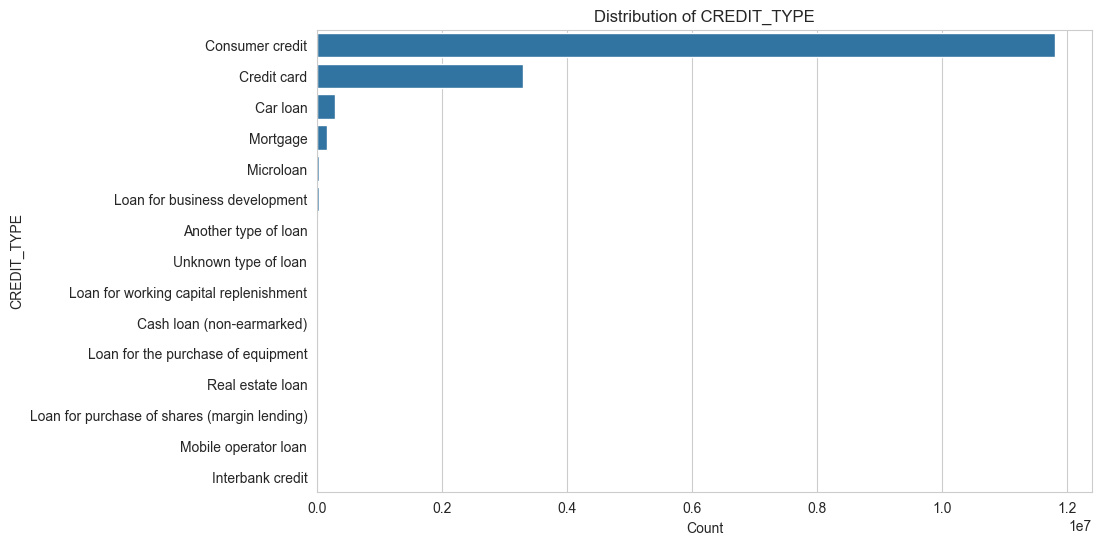

In [172]:
plot_count_distribution(bureau_and_bureau_bal, 'CREDIT_TYPE')

The column 'CREDIT_TYPE' contains many different types of credit, but some types appear only a few times. To simplify the data and avoid issues when some credit types have too little information for analysis, replace all credit types with a single category 'Other', except for 'Consumer credit', 'Credit card', 'Car loan' and 'Mortgage'.

In [173]:
bureau_and_bureau_bal['CREDIT_TYPE'] = bureau_and_bureau_bal['CREDIT_TYPE'].replace([
            'Microloan',
            'Loan for business development', 
            'Another type of loan',
            'Unknown type of loan', 
            'Loan for working capital replenishment',
            "Loan for purchase of shares (margin lending)",                                                
            'Cash loan (non-earmarked)', 
            'Real estate loan',
            "Loan for the purchase of equipment", 
            "Interbank credit", 
            "Mobile operator loan"], 'Other')

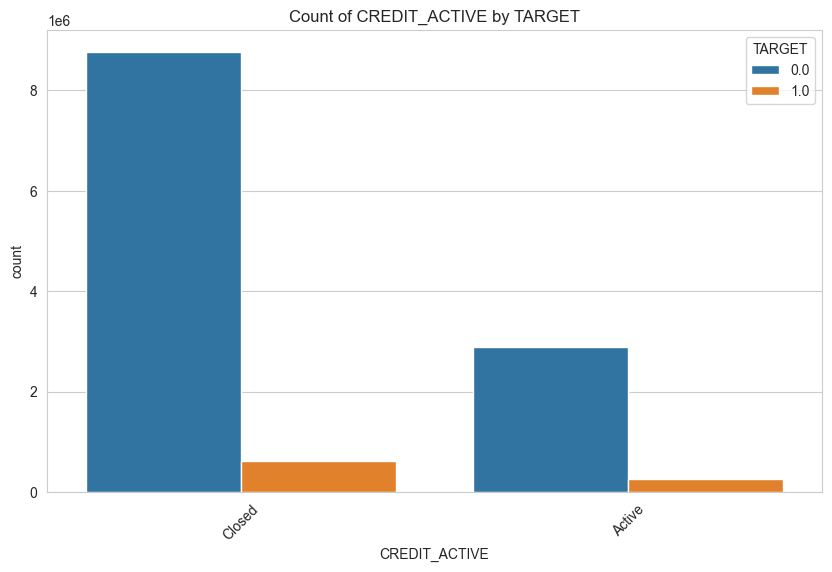

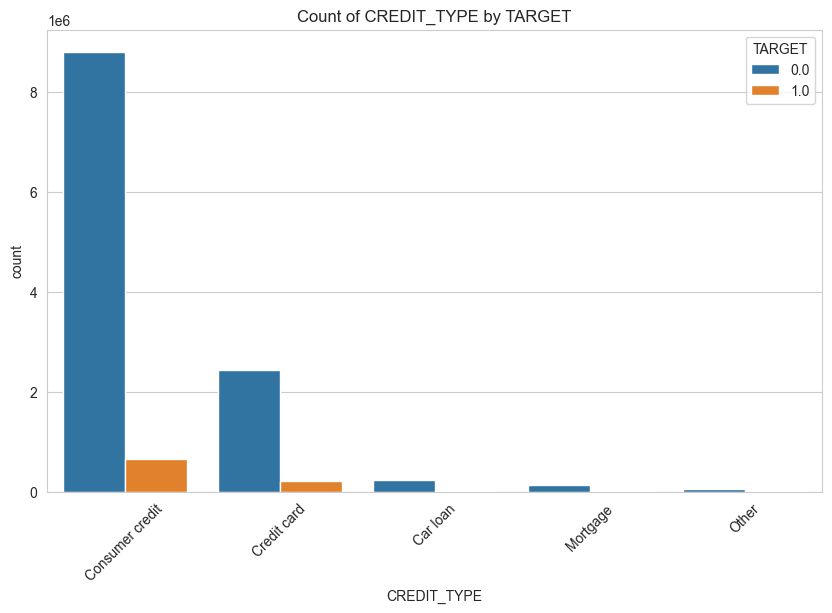

In [174]:
plot_count_by_target_bar(bureau_and_bureau_bal, ['CREDIT_ACTIVE', 'CREDIT_TYPE'], 'TARGET')

From 2 the charts above, we can see that the imbalance in TARGET's values since non-defaulted cases outweight defaulted cases

# Numerical variables 

In [175]:
numerical_columns = bureau_and_bureau_bal.select_dtypes('number').columns
numerical_columns

Index(['SK_ID_BUREAU', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY', 'SK_ID_CURR', 'TARGET', 'MONTHS_BALANCE'],
      dtype='object')

### DAYS_CREDIT 
This column describes about the number of days before current application when the client applied for Credit Bureau Credit. For ease of interpretability, we will convert these days to years.

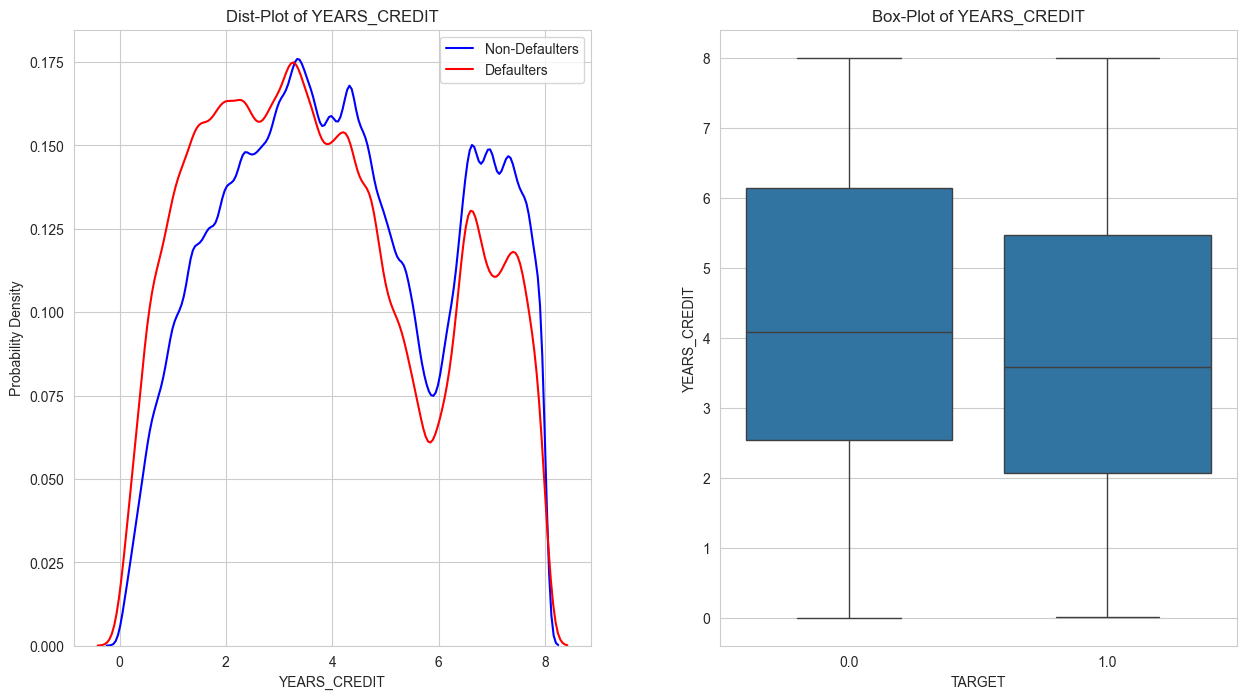

In [176]:
bureau_and_bureau_bal['YEARS_CREDIT'] = bureau_and_bureau_bal['DAYS_CREDIT'] / -365
plot_continuous_variables(bureau_and_bureau_bal, 'YEARS_CREDIT', plots = ['distplot', 'box'], figsize = (15,8))
_ = bureau_and_bureau_bal.pop('YEARS_CREDIT')

- Both default and non-default individuals have similar credit year distribution, with the peak of the distribution in the same range.
- This may indicate that the number of credit years does not provide enough discriminatory power to predict default likelihood.
- From the box-plot, we see that Defaulters usually had less YEARS_CREDIT as compared to Non-Defaulters.

### DAYS_CREDIT_ENDDATE

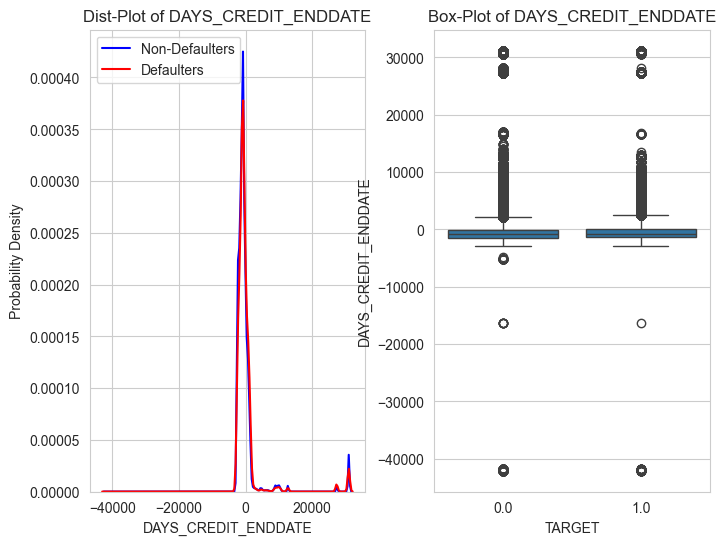

In [177]:
plot_continuous_variables(bureau_and_bureau_bal, 'DAYS_CREDIT_ENDDATE', plots = ['distplot','box'], figsize = (8,6))


In [178]:
print_percentiles(bureau_and_bureau_bal, 'DAYS_CREDIT_ENDDATE', percentiles = list(range(0,11,2)) + [25,50,75,100])

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_CREDIT_ENDDATE is -42060.0
The 2th percentile value of DAYS_CREDIT_ENDDATE is -2548.0
The 4th percentile value of DAYS_CREDIT_ENDDATE is -2449.0
The 6th percentile value of DAYS_CREDIT_ENDDATE is -2358.0
The 8th percentile value of DAYS_CREDIT_ENDDATE is -2276.0
The 10th percentile value of DAYS_CREDIT_ENDDATE is -2190.0
The 25th percentile value of DAYS_CREDIT_ENDDATE is -1559.0
The 50th percentile value of DAYS_CREDIT_ENDDATE is -838.0
The 75th percentile value of DAYS_CREDIT_ENDDATE is -54.0
The 100th percentile value of DAYS_CREDIT_ENDDATE is 31199.0
----------------------------------------------------------------------------------------------------


From the above percentile values, and looking at the box-plot, we see that there seems to be erroneous value for DAYS_CREDIT_ENDDATE, where the 0th percentile value dates back to as long as 42060 days or 115 years. This does not make much sense as this implies that the previous loan the client had dates back to 115 years ago. This could be inherited loan too, but we cannot comment so surely about that. We would try to remove these values (> 100 years) in the data preprocessing stage.

### DAYS_ENDDATE_FACT

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_ENDDATE_FACT is -42023.0
The 2th percentile value of DAYS_ENDDATE_FACT is -2568.0
The 4th percentile value of DAYS_ENDDATE_FACT is -2467.0
The 6th percentile value of DAYS_ENDDATE_FACT is -2375.0
The 8th percentile value of DAYS_ENDDATE_FACT is -2291.0
The 10th percentile value of DAYS_ENDDATE_FACT is -2196.0
The 25th percentile value of DAYS_ENDDATE_FACT is -1533.0
The 50th percentile value of DAYS_ENDDATE_FACT is -851.0
The 75th percentile value of DAYS_ENDDATE_FACT is 99999.0
The 100th percentile value of DAYS_ENDDATE_FACT is 99999.0
----------------------------------------------------------------------------------------------------


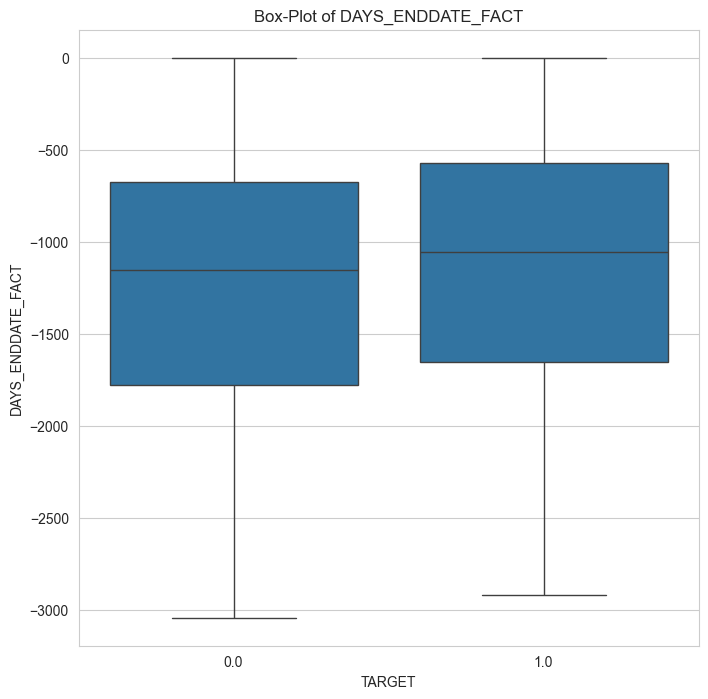

----------------------------------------------------------------------------------------------------


In [179]:
print_percentiles(bureau_and_bureau_bal, 'DAYS_ENDDATE_FACT', percentiles = list(range(0,11,2)) + [25,50,75,100])
plot_continuous_variables(bureau_and_bureau_bal, 'DAYS_ENDDATE_FACT', plots = ['box'], figsize = (8,8), scale_limits = [-40000, 0])
print('-'*100)

- Just like previous column, we see that the 0th percentile for this column also seems erroneous, which is 42023 days or ~115 years. We would have to remove these values, as they don't make much sense.
- Looking at the box-plot, we see that the Defaulters tend to have lesser number of days since their Credit Bureau credit had ended. The Non-Defaulters usually have their previous credits ended longer before than Defaulters.

### Early payment

In [180]:
bureau_and_bureau_bal['Early_pay'] = bureau_and_bureau_bal['DAYS_ENDDATE_FACT'] - bureau_and_bureau_bal['DAYS_CREDIT_ENDDATE']
bureau_and_bureau_bal['Early_pay'] = bureau_and_bureau_bal['Early_pay'].apply(lambda x: 1 if x <= 0 else 0) # 1 if early and ontime pay else 0

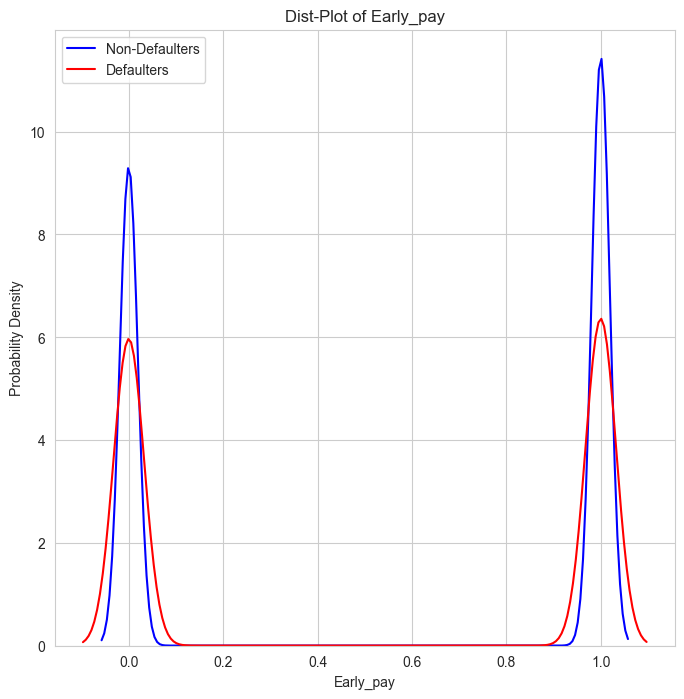

----------------------------------------------------------------------------------------------------


In [181]:
plot_continuous_variables(bureau_and_bureau_bal, 'Early_pay', plots = ['distplot'], figsize = (8,8), scale_limits = [-40000, 400])
print('-'*100)

- The non-defaulter tends to have more early payment than the defaulter

### DAYS_CREDIT_UPDATE

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_CREDIT_UPDATE is -41947.0
The 2th percentile value of DAYS_CREDIT_UPDATE is -2483.0
The 4th percentile value of DAYS_CREDIT_UPDATE is -2340.0
The 6th percentile value of DAYS_CREDIT_UPDATE is -2183.0
The 8th percentile value of DAYS_CREDIT_UPDATE is -2030.0
The 10th percentile value of DAYS_CREDIT_UPDATE is -1861.0
The 25th percentile value of DAYS_CREDIT_UPDATE is -1164.0
The 50th percentile value of DAYS_CREDIT_UPDATE is -726.0
The 75th percentile value of DAYS_CREDIT_UPDATE is -169.0
The 100th percentile value of DAYS_CREDIT_UPDATE is 372.0
----------------------------------------------------------------------------------------------------


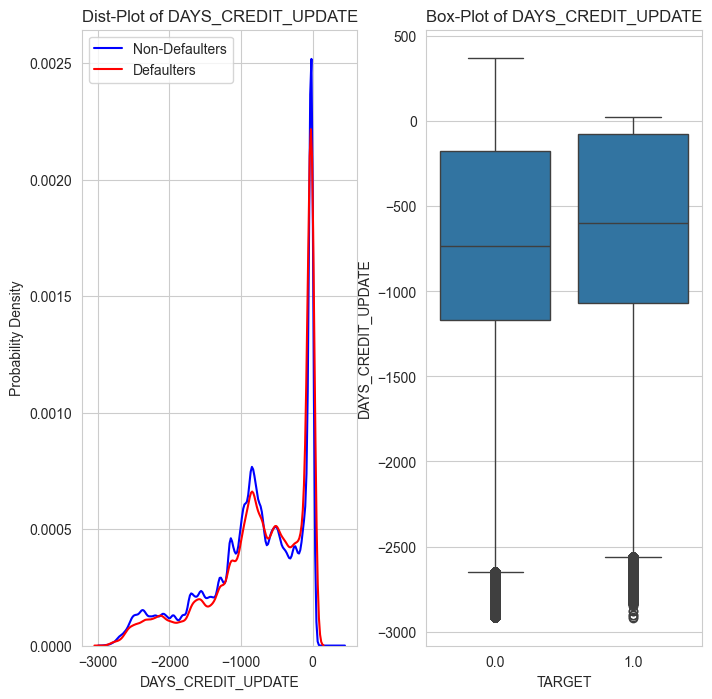

----------------------------------------------------------------------------------------------------


In [182]:
print_percentiles(bureau_and_bureau_bal, 'DAYS_CREDIT_UPDATE', percentiles = list(range(0,11,2)) + [25,50,75,100])
plot_continuous_variables(bureau_and_bureau_bal, 'DAYS_CREDIT_UPDATE', plots = ['distplot','box'], figsize = (8,8), scale_limits = [-40000, 400])
print('-'*100)

- From the box-plot, we can say that the Defaulters tend to have a lesser number of days since their Information about the Credit Bureau Credit were received. Their median, 75th percentile values all are lesser than those for Non-Defaulters.
- The trend of erroneious values is again very similar to the other days column where this 0th percentile value seems to be erroneous.

In [183]:
# Filter the dataframe
filtered_df = bureau_and_bureau_bal[
    (bureau_and_bureau_bal['DAYS_CREDIT_ENDDATE'] < -36500) |
    (bureau_and_bureau_bal['DAYS_ENDDATE_FACT'] < -36500) |
    (bureau_and_bureau_bal['DAYS_CREDIT_UPDATE'] < -36500)
]

filtered_df

,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR,TARGET,MONTHS_BALANCE,STATUS,Early_pay
8316,5716863,Closed,-331,0,765.0,-208.0,0.00,0,16414.245,0.0,16414.245,0.0,Credit card,-41857,0.0,272028,0.0,NaN,NaN,1
247916,5200446,Closed,-488,0,608.0,-457.0,0.00,0,72859.500,0.0,72859.500,0.0,Credit card,-41913,0.0,249347,0.0,NaN,NaN,1
269041,5800600,Active,-281,0,815.0,99999.0,0.00,0,225000.000,0.0,0.000,0.0,Credit card,-41906,0.0,289054,0.0,NaN,NaN,0
269114,5800677,Closed,-364,0,732.0,-294.0,0.00,0,450000.000,0.0,450000.000,0.0,Credit card,-41886,0.0,253416,NaN,NaN,NaN,1
384208,5214311,Active,-1226,0,-130.0,99999.0,0.00,0,225000.000,0.0,0.000,0.0,Credit card,-41900,0.0,240347,0.0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15406420,5639191,Closed,-259,0,837.0,-227.0,0.00,0,135000.000,0.0,135000.000,0.0,Credit card,-41853,0.0,272744,0.0,NaN,NaN,1
15514324,6649929,Closed,-2783,0,-41823.0,-674.0,0.00,0,0.000,0.0,0.000,0.0,Credit card,-674,0.0,14301,NaN,NaN,NaN,0
15514794,6650455,Closed,-265,0,831.0,-234.0,0.00,0,262619.640,0.0,262619.640,0.0,Credit card,-41854,0.0,271213,0.0,NaN,NaN,1
15593973,5571289,Closed,-2252,0,-41846.0,-457.0,10323.36,0,0.000,0.0,0.000,0.0,Credit card,-457,0.0,181809,0.0,NaN,NaN,0


In [199]:
filtered_df[filtered_df['DAYS_ENDDATE_FACT'] != 99999]

,SK_ID_BUREAU,CREDIT_ACTIVE,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR,TARGET,MONTHS_BALANCE,STATUS,Early_pay
8316,5716863,Closed,-331,0,765.0,-208.0,0.00,0,16414.245,0.0,16414.245,0.0,Credit card,-41857,0.0,272028,0.0,NaN,NaN,1
247916,5200446,Closed,-488,0,608.0,-457.0,0.00,0,72859.500,0.0,72859.500,0.0,Credit card,-41913,0.0,249347,0.0,NaN,NaN,1
269114,5800677,Closed,-364,0,732.0,-294.0,0.00,0,450000.000,0.0,450000.000,0.0,Credit card,-41886,0.0,253416,NaN,NaN,NaN,1
510729,5006959,Closed,-292,0,804.0,-230.0,0.00,0,65529.000,0.0,65529.000,0.0,Credit card,-41878,0.0,48334,0.0,NaN,NaN,1
694498,5573519,Closed,-1224,0,-128.0,-1223.0,0.00,0,4500.000,0.0,4500.000,0.0,Credit card,-41884,0.0,163230,0.0,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15406420,5639191,Closed,-259,0,837.0,-227.0,0.00,0,135000.000,0.0,135000.000,0.0,Credit card,-41853,0.0,272744,0.0,NaN,NaN,1
15514324,6649929,Closed,-2783,0,-41823.0,-674.0,0.00,0,0.000,0.0,0.000,0.0,Credit card,-674,0.0,14301,NaN,NaN,NaN,0
15514794,6650455,Closed,-265,0,831.0,-234.0,0.00,0,262619.640,0.0,262619.640,0.0,Credit card,-41854,0.0,271213,0.0,NaN,NaN,1
15593973,5571289,Closed,-2252,0,-41846.0,-457.0,10323.36,0,0.000,0.0,0.000,0.0,Credit card,-457,0.0,181809,0.0,NaN,NaN,0


## Bureau Balance

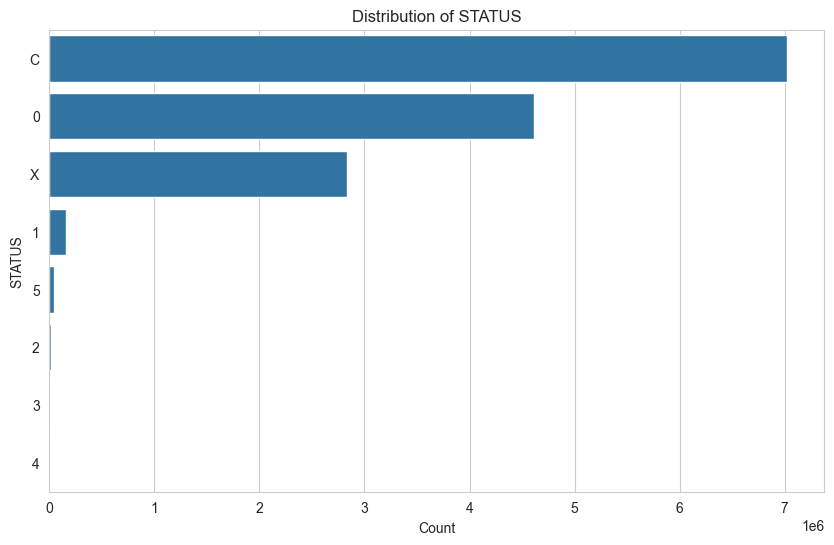

In [57]:
plot_count_distribution(bureau_and_bureau_bal, 'STATUS')

In [58]:
status_df = bureau_and_bureau_bal.groupby(['SK_ID_CURR', 'TARGET']).agg({'STATUS': 'unique'}).reset_index()

In [59]:
status_df.head()

,SK_ID_CURR,TARGET,STATUS
0,0,0.0,[nan]
1,1,1.0,"[C, 0]"
2,2,0.0,[nan]
3,3,0.0,[nan]
4,4,0.0,[nan]


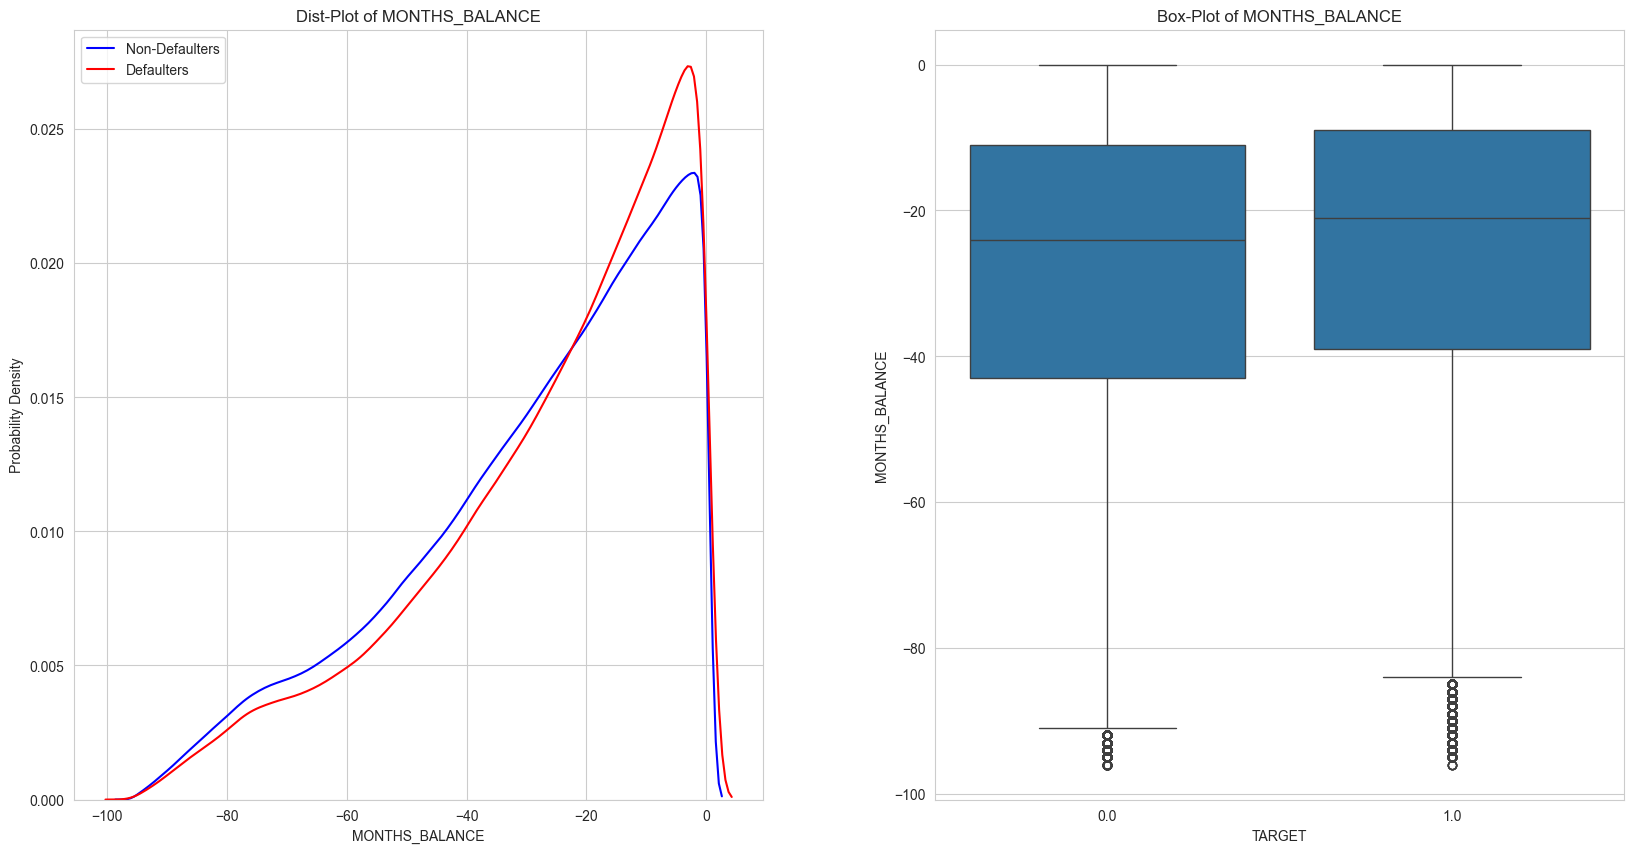

In [ ]:
plot_continuous_variables(bureau_and_bureau_bal, 'MONTHS_BALANCE', plots=['distplot','box'], figsize=(20,10))

- Both charts show that there is no clear distinction between the defaulters and non-defaulters groups based on the "MONTHS_BALANCE" value alone. Both groups have similar distributions, and their medians are almost identical.

- There is a high degree of overlap between the two groups, indicating that "MONTHS_BALANCE" may not be a strong independent variable for predicting a customer's likelihood of default.